# Coarse Grained Monte Carlo (MC) Simulations For Osmotic Second Virial Coefficient Calculations

## Note

In order to run this notebook you need to install the package mdtraj. Info about installation can be found here:http://mdtraj.org/latest/installation.html.

## Purpose

The purpose of this notebook is to perform Monte Carlo simulations at amino acid coarse grained level to calculate osmotic second virial coefficient of proteins in different salt conditions and pH.


## Theory

Protein aggregation is a issue for biopharmaceutical industry and the ability to predict aggregation is crucial for the formulation of new protein-based drugs. Current prediction models account for conformational factor, defined as the difference in free energy between the folded and unfolded states and colloidal factor, defined as the balance of repulsive and attractive intermolecular interactions.

The osmotic second virial coefficient ($B_{2}$) is a measure of colloidal stability. It represents the first-order correction to the ideal gas law accounting for intermolecular interactions at two-body level, i.e., it describes dilute solutions where the interactions can be treated as pairwise additive.

\begin{equation}
\frac{p}{k_{b}T}= \rho + B_{2}(T)\rho^{2}+B_{2}\rho^{3} + ...
\end{equation}

It is defined as:

\begin{equation}
B_{2}=-2\pi \int_{0}^{\infty} (e^{lng(r)}-1)r_{12}^{2}dr_{12},
\end{equation}

where $g(r)$ is the radial distribution function, which gives the probability of finding a protein at a separation r 
from the other, compared to a ideal gas distribution.

## Model

The model consists of two proteins (in this case indentical) in a cylindrical space, modelled as a collection of particles, each representing one amino acid.
<img src="Model.png" alt="Drawing" style="width: 600px;"/>

The proteins are allowed to translate along z-axis and rotate around vectors going through their center of mass. The protonation states of each amino acid can also change according to the pH. Implicit salt and solvent are used.


## Load a pdb and coarse grain it at amino acid level

Before starting the MC simulations we need the coarse-grained structure. This part of the code loads a pdb from the Protein Data Bank https://www.rcsb.org/pdb/home/home.do and coarse grain it at amino acid level (each amino acid is replaced by a sphere) giving as output a file.aam that will be used for the simulations. For this notebook a small protein called plectasin will be used.

In [1]:
workdir=%pwd   
import mdtraj as md
import numpy as np


traj=md.load_pdb('https://files.rcsb.org/view/1ZFU.pdb')  #Url for pdb structure                                 
                                               
for chain in traj.topology.chains:
    print('chain: ', chain.index)
    # filter pdb to only select protein(s)
    sel = chain.topology.select('protein')
    top = chain.topology.subset(sel)
    f = open('chain'+str(chain.index)+'.aam','w')
    f.write(str(top.n_residues)+'\n')
    
      
# loop over residues and calculate residue mass centers, radius, and weight 

for res in top.residues:
    if res.is_protein:
        cm = [0,0,0] # residue mass center
        mw = 0       # residue weight
        for a in res.atoms:
            cm = cm + a.element.mass * traj.xyz[0][a.index]
            mw = mw + a.element.mass
        cm = cm/mw*10
        radius = ( 3./(4*np.pi)*mw/1.0 )**(1/3.)
        f.write('{0:4} {1:5} {2:8.3f} {3:8.3f} {4:8.3f} {5:6.3f} {6:6.2f} {7:6.2f}\n'\
                .format(res.name,res.index,cm[0],cm[1],cm[2],0,mw,radius))
file = 'chain'+str(chain.index)+'.aam'
f.close()

chain:  0


//anaconda/lib/python3.5/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


## Download and compile Faunus

Faunus (https://github.com/mlund/faunusis) is a software for Monte Carlo simulations. In this part of the code we download and compile it. Then, the executable file (twobody) is copied into the work directory.


In [2]:
%%bash

if [ ! -d "faunus" ]; then  # Se la cartella (-d) "faunus" non (! inverte l'uscira dell'operatore che segue) esiste, allora...
  git clone https://github.com/mlund/faunus.git
  cd faunus
else
  cd faunus
fi # (equivalente ad end if)

cp ../twobody.cpp src/examples/ #Prima di compilare copia la versione modificata di twobody.cpp

cmake . -DCMAKE_BUILD_TYPE=RelWithDebInfo 
make example_twobody -j4

cp src/examples/twobody ../
cd ..

-- The C compiler identification is AppleClang 9.0.0.9000039
-- The CXX compiler identification is AppleClang 9.0.0.9000039
-- Check for working C compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/cc
-- Check for working C compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/c++
-- Check for working CXX compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Eigen3: /Users/michael/Desktop/project/faunus/include/e

Cloning into 'faunus'...
...............................................................
  Faunus is compiled in Debug mode to enable checks and
  assertions highly recommended when developing and testing.
  For production, switch to Release for optimal performance:

  -DCMAKE_BUILD_TYPE=Release
***************************************************************



## Input for Faunus

Model details as physical parameters, size of the simulation box, the number of step to be performed, can be changed in this part of the code. A json file containing all these parameters will be created.

In [58]:
#Load modules

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import json

###              ###
#SET OF PARAMETES#
###              ###

#Energy
epsr=78.7
mindist=0    # minimum allowed COM-COM distance (angstrom)
maxdist=200  # maximum allowed COM-COM distance (angstrom)    

#System
cylradius=55 # cylinder radius (angstrom)
cyllen=400   # cylinder length (angstrom)


#Moves
dp=15        # COM translational displacement parameter (angstrom)

#Moleculelist
offset=40    # initial COM-COM separation (angstrom)

#Analysis  
nstep_xtc=100  # frequency for saving frames to xtc trajectory file

#Atomlist
ljeps=0.12350 # LJ epsilon (kT)

#Number of step 
micro = 50000
macro = 100

#Function that determines the Debye Length corresponding to the salt concentration

def debye(conc):
    ''' Convert salt concentration (in M) to Debye lenght. 
        Valid at room temperature (25 °C) for 1:1 electrolytes.'''
    return 3.04/np.sqrt(conc)


#Function for input file
def mkinput():
    js = {
              "energy" : {
                  "___eqstate": { "processfile": "twobody.json" },
                  "nonbonded" : { "epsr" : 78.7, "coulombtype": "yukawa", "cutoff":2*D, "debyelength": D},
                  "cmconstrain" : {"0sphere 1sphere" : { "mindist": mindist, "maxdist": maxdist }}
                         },
                
               "system" : {
                  "temperature" : 298.15,
                  "geometry" : { "length" : cyllen, "radius" : cylradius },
                  "mcloop"   : { "macro" : macro, "micro" : micro }
                          },
                 
                "moves" : {
                  
                    #1
                    "titrate" : {
                      "prob":0.2,
                      "processes" : {
                            "H-Asp" : { "bound":"HASP" , "free":"ASP" , "pKd":4.0  , "pX":pH },
                            "H-Ctr" : { "bound":"HCTR" , "free":"CTR" , "pKd":2.6  , "pX":pH },
                            "H-Glu" : { "bound":"HGLU" , "free":"GLU" , "pKd":4.4  , "pX":pH },
                            "H-His" : { "bound":"HHIS" , "free":"HIS" , "pKd":6.3  , "pX":pH },
                            "H-Arg" : { "bound":"HARG" , "free":"ARG" , "pKd":12.0 , "pX":pH },
                            "H-Ntr" : { "bound":"HNTR" , "free":"NTR" , "pKd":7.5  , "pX":pH },
                            "H-Cys" : { "bound":"HCYS" , "free":"CYS" , "pKd":10.8 , "pX":pH },
                            "H-Tyr" : { "bound":"HTYR" , "free":"TYR" , "pKd":9.6  , "pX":pH },
                            "H-Lys" : { "bound":"HLYS" , "free":"LYS" , "pKd":10.4 , "pX":pH }
                                    }
                                },
                    #2
                    "moltransrot2body" : {
                    "0sphere" : { "dp":dp, "dprot":0.5 }, 
                    "1sphere" : { "dp":dp, "dprot":0.5 } 
                                         }
                         },
                
                "moleculelist": {
                  "0sphere":  { "structure":xyzfile, "Ninit":1, "insdir":"0 0 0", "insoffset":"0 0 "+str(offset)},
                  "1sphere":  { "structure":xyzfile, "Ninit":1, "insdir":"0 0 0", "insoffset":"0 0 -"+str(offset)}
                                },
        
                 "analysis" : {
                   "pqrfile" : { "file": "confout.pqr"  }, 
                   "chargemultipole": {"mollist" : ["0sphere","1sphere"], "nstep":10 },
                   "molrdf" : { "nstep":1, "pairs" : 
                            [ { "name1":"0sphere", "name2":"1sphere", "file":"rdf.dat", "dr":0.1, "dim":1 }]
                              },
                   "xtcfile" : { "file": "traj.xtc", "nstep": nstep_xtc },

                              },
            
                 "atomlist" : {
                    "ASP":  dict(q=-1, sigma=5.94, eps=ljeps, mw=110.05),
                    "HASP": dict(q=0,  sigma=5.94, eps=ljeps, mw=110.05),

                    "GLU":  dict(q=-1, sigma=6.16, eps=ljeps, mw=122.06),
                    "HGLU": dict(q=0,  sigma=6.16, eps=ljeps, mw=122.06),
                    
                    "HIS":  dict(q=0,  sigma=6.28, eps=ljeps, mw=130.08),
                    "HHIS": dict(q=1,  sigma=6.28, eps=ljeps, mw=130.08),
                    
                    "ARG":  dict(q=0,  sigma=6.66, eps=ljeps, mw=155.18),
                    "HARG": dict(q=1,  sigma=6.66, eps=ljeps, mw=155.18),
                     
                    "BCYS": dict(q=0, sigma=5.72, eps=ljeps, mw=98.10),
                    "CYS":  dict(q=-1, sigma=5.72, eps=ljeps, mw=98.10),
                    "HCYS": dict(q=0,  sigma=5.72, eps=ljeps, mw=98.10),
                    
                    "TYR":  dict(q=-1, sigma=6.66, eps=ljeps, mw=154.10),
                    "HTYR": dict(q=0,  sigma=6.66, eps=ljeps, mw=154.10),
                    
                    "LYS":  dict(q=0,  sigma=6.06, eps=ljeps, mw=116.08),
                    "HLYS": dict(q=1,  sigma=6.06, eps=ljeps, mw=116.08),
                    
                    "NTR": dict(q=0,  sigma=4.70, eps=ljeps, mw=54.03), #gly was N terminal
                    "HNTR": dict(q=1,  sigma=4.70, eps=ljeps, mw=54.03),
                    
                    "CTR": dict(q=-1,  sigma=4.70, eps=ljeps, mw=16.00), #TYR (tritable) is C terminal
                    "HCTR.": dict(q=0,  sigma=4.70, eps=ljeps, mw=16.00),
                     
                    "MET":  dict(q=0,  sigma=3.8, eps=ljeps,  mw=122),
                     
                    "GLN":  dict(q=0,  sigma=3.8, eps=ljeps,  mw=120),

                    "ASN":  dict(q=0,  sigma=5.58, eps=ljeps, mw=112.09),
                     
                    "GLY":  dict(q=0,  sigma=4.70, eps=ljeps, mw=54.03),

                    "PHE":  dict(q=0,  sigma=6.42, eps=ljeps, mw=138.10),

                    "PRO":  dict(q=0,  sigma=5.56, eps=ljeps, mw=90.06),

                    "TRP":  dict(q=0,  sigma=6.96, eps=ljeps, mw=176.13),

                    "LEU":  dict(q=0,  sigma=5.58, eps=ljeps, mw=111.14), 
                    
                    "SER":  dict(q=0,  sigma=5.40, eps=ljeps, mw=82.04),

                    "ILE":  dict(q=0,  sigma=5.80, eps=ljeps, mw=102.07),

                    "ALA":  dict(q=0,  sigma=5.02, eps=ljeps, mw=66.04),

                    "VAL":  dict(q=0,  sigma=5.56, eps=ljeps, mw=90.06),   
                }
        
    }


    json_str = json.dumps(js)


    with open('twobody.json', 'w') as f:
        json.dump(js, f, indent=4)


#Dictionary of proteins

proteins = {
    'Protein': {
        'xyzfile':'../../../chain0.aam',
        'conc': [0.02,0.06], 'pH': [3,4,5,6]
               }
           }
 
    
#Loop to run simulation for different salt conditions and pHs

for name, prop in proteins.items():
    xyzfile = prop['xyzfile']
    %mkdir $name
    %cd $name
    for csalt in prop ['conc']:
        %mkdir $csalt
        %cd $csalt
        for pH in prop['pH']:
            %mkdir $pH
            %cd $pH
            D =debye(csalt)
            !rm -f state
            mkinput()
            ! ../../../twobody > out
            %cd -q ../
        %cd -q ../    
   

mkdir: Protein: File exists
/Users/michael/Desktop/project/Protein
mkdir: 0.02: File exists
/Users/michael/Desktop/project/Protein/0.02
mkdir: 3: File exists
/Users/michael/Desktop/project/Protein/0.02/3
State file not found.
mkdir: 4: File exists
/Users/michael/Desktop/project/Protein/0.02/4
State file not found.
mkdir: 5: File exists
/Users/michael/Desktop/project/Protein/0.02/5
State file not found.
mkdir: 6: File exists
/Users/michael/Desktop/project/Protein/0.02/6
State file not found.
mkdir: 0.06: File exists
/Users/michael/Desktop/project/Protein/0.06
mkdir: 3: File exists
/Users/michael/Desktop/project/Protein/0.06/3
State file not found.
mkdir: 4: File exists
/Users/michael/Desktop/project/Protein/0.06/4
State file not found.
mkdir: 5: File exists
/Users/michael/Desktop/project/Protein/0.06/5
State file not found.
mkdir: 6: File exists
/Users/michael/Desktop/project/Protein/0.06/6
State file not found.
^C


## Plot of potential of the mean force (PMF) and $B_2$

Among the output, the rdf file contains the radial distribution function g(r) that gives the probability of finding a protein at a separation r from the other, compared to a ideal gas distribution. g(r) is related to the potential of the mean force (PMF), that is the orientationally averaged interaction free energy between two protein molecules, by the relation: 

\begin{equation}
PMF=-kT \ln g(r).
\end{equation}

In this part of the code, are shown plots of PMF for different salt conditions and pHs and the corresponding $B_{2}$ values calulated according to the relation 

\begin{equation}
B_{2}=-2\pi \int_{0}^{\infty} (e^{-PMF/kT}-1)r_{12}^{2}dr_{12}.
\end{equation}


[Errno 2] No such file or directory: 'protein/'
/Users/michael/Desktop/project/Protein
[Errno 2] No such file or directory: 'Plectasin/'
/Users/michael/Desktop/project/Protein
/Users/michael/Desktop/project/Protein/0.02
/Users/michael/Desktop/project/Protein/0.02/3
/Users/michael/Desktop/project/Protein/0.02
/Users/michael/Desktop/project/Protein/0.02/4
/Users/michael/Desktop/project/Protein/0.02
/Users/michael/Desktop/project/Protein/0.02/5
/Users/michael/Desktop/project/Protein/0.02
/Users/michael/Desktop/project/Protein/0.02/6
/Users/michael/Desktop/project/Protein/0.02


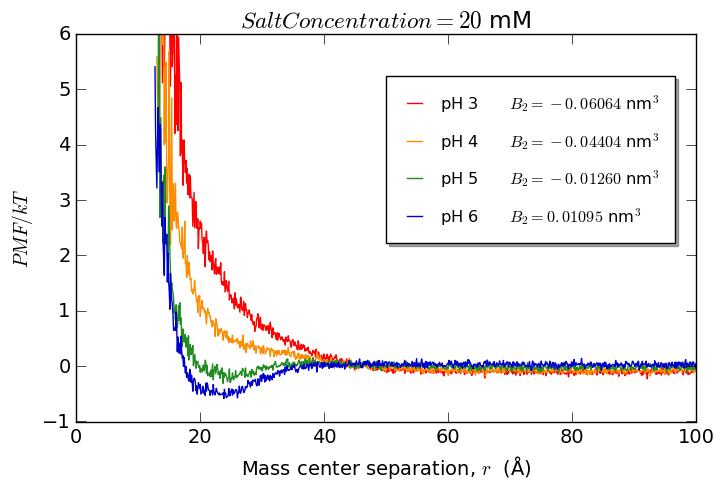

/Users/michael/Desktop/project/Protein
/Users/michael/Desktop/project/Protein/0.06
/Users/michael/Desktop/project/Protein/0.06/3
/Users/michael/Desktop/project/Protein/0.06
/Users/michael/Desktop/project/Protein/0.06/4
/Users/michael/Desktop/project/Protein/0.06
/Users/michael/Desktop/project/Protein/0.06/5
/Users/michael/Desktop/project/Protein/0.06
/Users/michael/Desktop/project/Protein/0.06/6
/Users/michael/Desktop/project/Protein/0.06


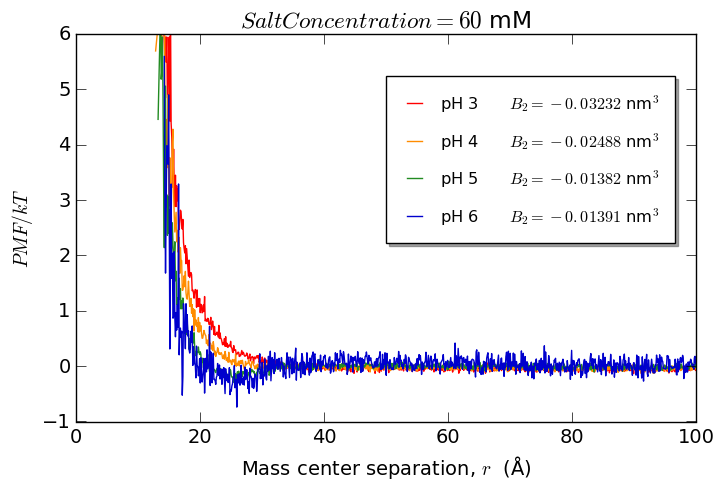

/Users/michael/Desktop/project/Protein
/Users/michael/Desktop/project


In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

%cd protein/
    
#Dictionary

proteins = {
    'Plectasin': {
        'xyzfile':'../../../chain0.aam',
        'conc': [0.02,0.06], 'pH': [3,4,5,6]
    }
}

plt.rcParams.update({'font.size':14,'legend.frameon':True,'figure.figsize':[8,5],
                    'xtick.major.size':7,'ytick.major.size':7,
                    'legend.labelspacing':1})


B22=[]
for name, prop in proteins.items():
    %cd $name/
    for conc in prop['conc']:
        %cd $conc
        for pH,c in zip(prop['pH'],['r','darkorange','forestgreen','mediumblue']):
            %cd $pH
            x,y = np.loadtxt('rdf.dat',unpack=True)
            pmf=-np.log(y/y[:-100].mean())
            Mw=4400
            B2=-2*np.pi*np.trapz(np.expm1(-pmf)*x**2, x)*6.022e23*1e-24/Mw/Mw
            B22.append(B2)
            #plt.plot(x,pmf , '-', color=c,  label='pH '+str(pH), lw=2)
            #plt.plot(x, pmf, '-', color=c,  label='pH '+str(pH))
            plt.plot(x, pmf, '-', color=c,  label='pH '+str(pH)+'      $B_2={:1.5f}$'.format(B2)+' nm$^{3}$')
            
            plt.xlabel('Mass center separation, $r$  (Å)')
            plt.ylabel('$PMF/kT$')
            %cd ../
            
        plt.title('$Salt Concentration={:1.0f}$'.format(conc*1e3)+' mM')
        plt.legend(loc=(0.5,0.46),ncol=1,shadow=True,borderpad=1,handlelength=1.5, fontsize='small')
        #plt.xlim(0,25)
        #plt.ylim(-2,9)
        plt.axis([0,100, -1, 6])#Range del plot
        #plt.plot([0,199],[0,4],'k--', lw=2.5)
        #print(workdir+'/MC/'+name+'/'+str(conc)+'/gofr.pdf')
        #plt.savefig(workdir+'/MC/'+name+'/'+str(conc)+'/pmf.pdf')
        plt.show()
              
        
        %cd ../
    %cd ../
    